<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Selection-of-variables-that-truly-contribute-to-the-model:" data-toc-modified-id="Selection-of-variables-that-truly-contribute-to-the-model:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Selection of variables that truly contribute to the model:</a></span></li><li><span><a href="#Transformations" data-toc-modified-id="Transformations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transformations</a></span><ul class="toc-item"><li><span><a href="#Evaluation-of-distributions-and-application-of-relevant-transformations:" data-toc-modified-id="Evaluation-of-distributions-and-application-of-relevant-transformations:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluation of distributions and application of relevant transformations:</a></span></li></ul></li><li><span><a href="#Creating-the-models" data-toc-modified-id="Creating-the-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the models</a></span><ul class="toc-item"><li><span><a href="#KNeighborsClassifier" data-toc-modified-id="KNeighborsClassifier-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>KNeighborsClassifier</a></span></li><li><span><a href="#Decision-tree" data-toc-modified-id="Decision-tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision tree</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#Simple-NN-sequential-model-with-Relu-as-activation-function:" data-toc-modified-id="Simple-NN-sequential-model-with-Relu-as-activation-function:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Simple NN sequential model with Relu as activation function:</a></span></li><li><span><a href="#Simple-NN-sequential-model-with-Relu-as-activation-function-and-dropout-layers:" data-toc-modified-id="Simple-NN-sequential-model-with-Relu-as-activation-function-and-dropout-layers:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Simple NN sequential model with Relu as activation function and dropout layers:</a></span></li></ul></li><li><span><a href="#Model-comparative" data-toc-modified-id="Model-comparative-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model comparative</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [1]:
import os 
import pandas as pd 
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as sk_prep
from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '../Data'
incendios_path = 'generated_files/final_model_data.csv'

In [4]:
data = pd.read_csv(os.path.join(data_path, incendios_path), index_col = 0)

## Selection of variables that truly contribute to the model:

In [5]:
#Based on correlations and feature engineering
features = ['superficie', 'idprovincia', 'idmunicipio', 'time_ctrl', 'time_ext', 'month', 'Recursos_ha', 'Eficiencia', 'Y']
model_data_1 = data[features]

In [6]:
model_data_1.head()

,superficie,idprovincia,idmunicipio,time_ctrl,time_ext,month,Recursos_ha,Eficiencia,Y
83,1.01,4,54,180,239,1,2.970297,58.415842,1
1838,2.90,18,44,220,280,1,3.793103,20.689655,0
6212,3.00,43,86,160,340,1,11.000000,60.000000,0
1839,1.50,18,906,60,180,1,5.333333,80.000000,0
1815,3.00,17,132,70,140,2,4.000000,23.333333,0


In [7]:
def cause_per_year(df, field, count = False):
    if count:
        return df[field].value_counts().sort_index()
    return (df[field].value_counts().sort_index() / df.shape[0])*100

print('Proportion of observations based on the class to predict.')
cause_per_year(model_data_1, 'Y')

Proportion of observations based on the class to predict.


0    50.053374
1    49.946626
Name: Y, dtype: float64

## Transformations

### Evaluation of distributions and application of relevant transformations:

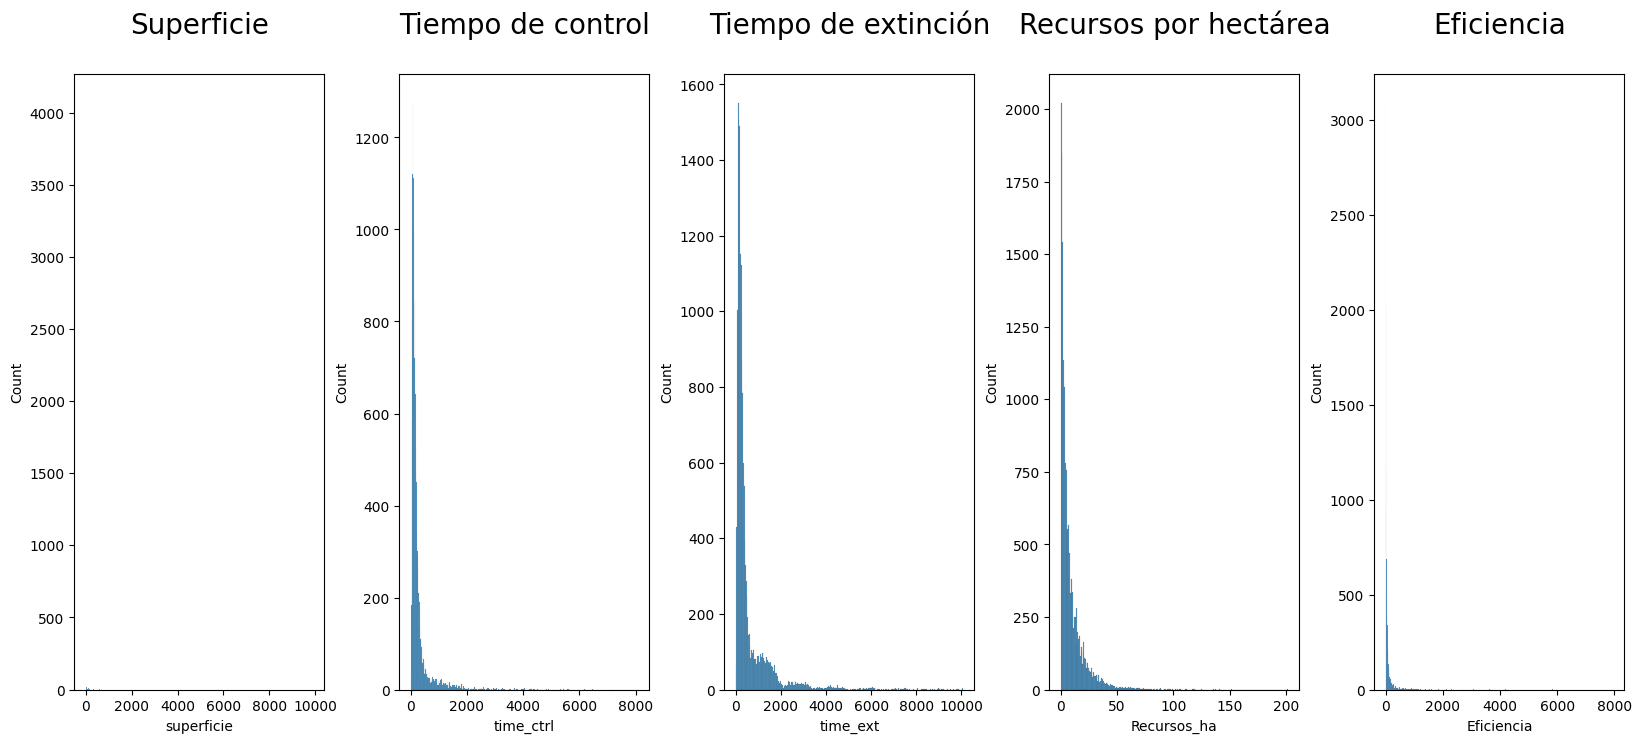

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.histplot(x = model_data_1['superficie'], ax = ax1)
sns.histplot(x = model_data_1['time_ctrl'], ax = ax2)
sns.histplot(x = model_data_1['time_ext'], ax = ax3)
sns.histplot(x = model_data_1['Recursos_ha'], ax = ax4)
sns.histplot(x = model_data_1['Eficiencia'], ax = ax5)
ax1.set_title('Superficie\n', fontsize = 20)
ax2.set_title('Tiempo de control\n', fontsize = 20)
ax3.set_title('Tiempo de extinción\n', fontsize = 20)
ax4.set_title('Recursos por hectárea\n', fontsize = 20)
ax5.set_title('Eficiencia\n', fontsize = 20)
plt.show()

While non-parametric models will be applied to predict the classes of interest, many of the algorithms that optimize model learning perform better with scaled (or compressed) data, normal distributions, or standardized data. In our case, given the distributions observed associated with the relevant numerical variables, we can consider data transformation.

Considering the geometry of the distributions, most of these variables might be exhibiting exponential or lognormal distributions (which actually makes sense given the nature of these variables as real and positive values). Therefore, we can explore an appropriate transformation based on the type of distribution observed. This would, to some extent, normalize the data. To evaluate the distributions of these variables, we can utilize the **Fitter** function from the fitter module, which provides functions to calculate the most probable distribution of a variable:

In [13]:
dist = ['lognorm', 'expon']
for variable in ['superficie','time_ctrl', 'time_ext', 'Recursos_ha', 'Eficiencia']:
    print(variable)
    array = model_data_1[variable]
    f = Fitter(array, distributions = dist)
    f.fit()
    print('More approximate distribution: ', list(f.get_best(method = 'sumsquare_error').keys())[0])

superficie
More approximate distribution:  expon
time_ctrl
More approximate distribution:  lognorm
time_ext
More approximate distribution:  lognorm
Recursos_ha
More approximate distribution:  lognorm
Eficiencia
More approximate distribution:  expon


In [10]:
def new_data (pandasSeries, transformation = 'lognorm', log_base = None):
    array = np.array(pandasSeries)
    if transformation == 'lognorm':
        if log_base:
            return eval(f'np.log{log_base}(array)')
        return np.log(array)
    elif transformation == 'Quantile':
        lenght = len(array)
        array = array.reshape(lenght,1)
        quantile = sk_prep.QuantileTransformer(output_distribution='normal')
        new_data = quantile.fit_transform(array)
        return new_data.reshape(lenght)

We will apply two types of transformations to the data:

* For exponential distributions, we will apply a QuantileTransformer transformation.
* For lognormal distributions, we will apply a logarithmic transformation.

In [11]:
new_surf = new_data (model_data_1['superficie'], transformation = 'Quantile')
new_time_ctrl = new_data (model_data_1['time_ctrl'], transformation = 'lognorm')
new_time_ext = new_data (model_data_1['time_ext'], transformation = 'lognorm')
new_Recursos_ha = new_data (model_data_1['Recursos_ha'], transformation = 'lognorm')
new_Eficiencia = new_data (model_data_1['Eficiencia'], transformation = 'Quantile')

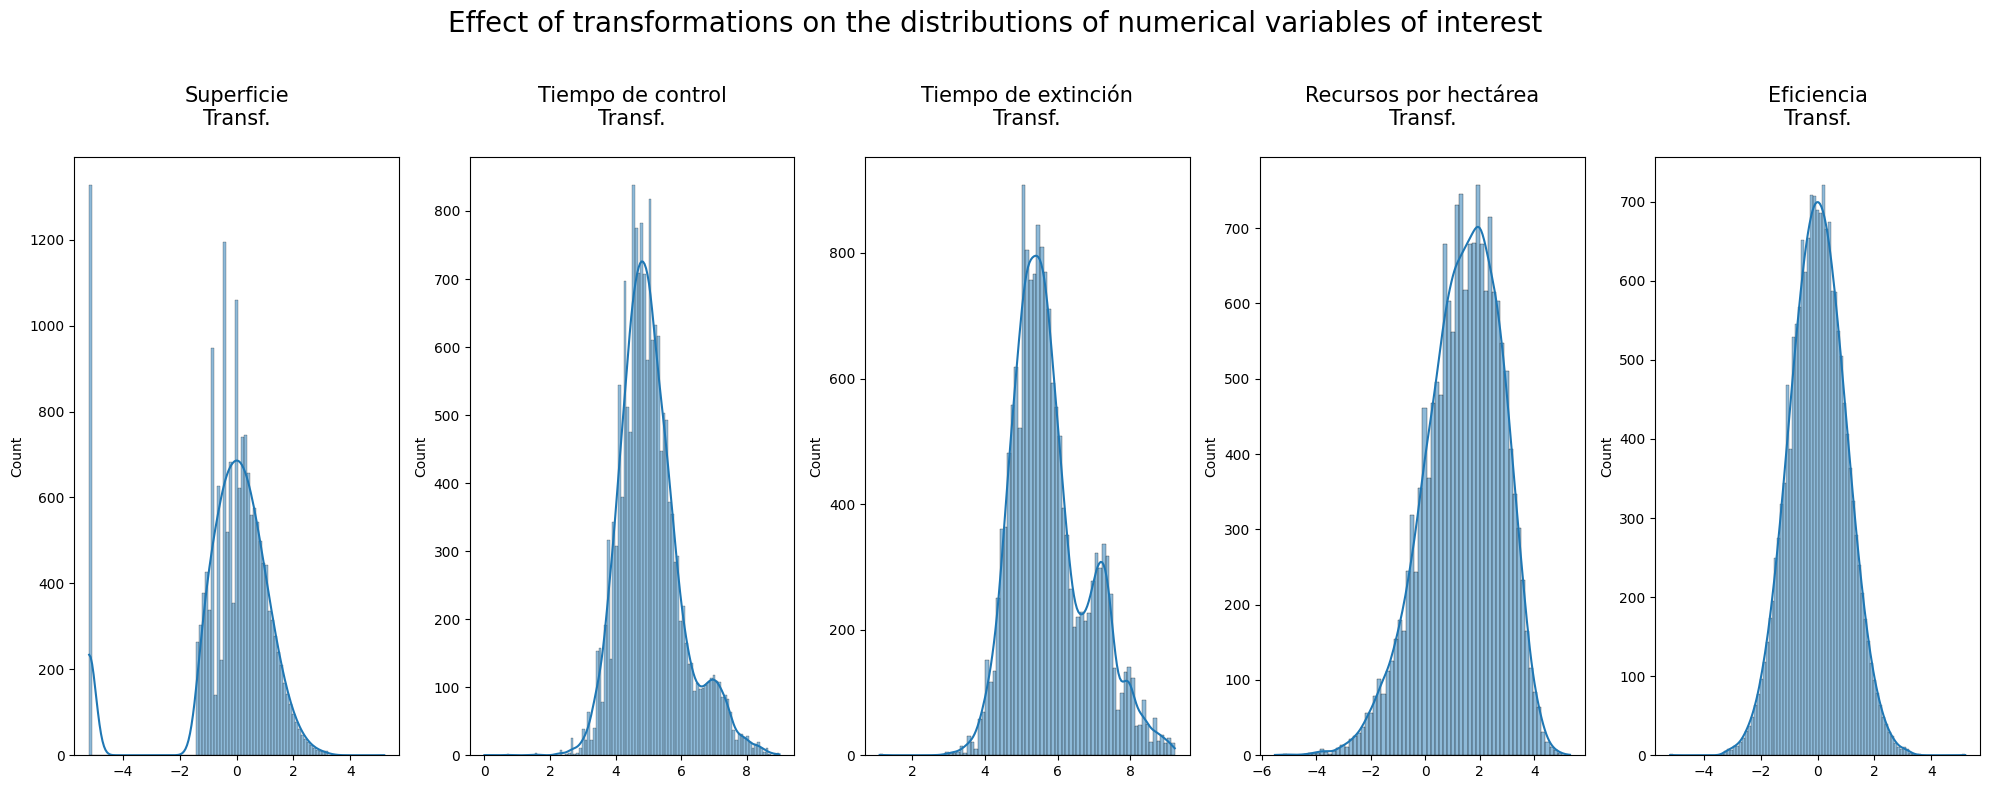

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.histplot(x = new_surf, ax = ax1, kde=True)
sns.histplot(x = new_time_ctrl, ax = ax2, kde=True)
sns.histplot(x = new_time_ext, ax = ax3, kde=True)
sns.histplot(x = new_Recursos_ha, ax = ax4,kde=True)
sns.histplot(x = new_Eficiencia, ax = ax5, kde=True)
ax1.set_title('Superficie\nTransf.\n', fontsize = 15)
ax2.set_title('Tiempo de control\nTransf.\n', fontsize = 15)
ax3.set_title('Tiempo de extinción\nTransf.\n', fontsize = 15)
ax4.set_title('Recursos por hectárea\nTransf.\n', fontsize = 15)
ax5.set_title('Eficiencia\nTransf.\n', fontsize = 15)
fig.suptitle('Effect of transformations on the distributions of numerical variables of interest\n', fontsize = 20)
fig.tight_layout()
plt.show()

## Creating the models

In [19]:
model_data_2 = model_data_1[['idprovincia', 'idmunicipio','month', 'Y']]
model_data_2['surf_transform'] = new_surf
model_data_2['time_ctrl_transform'] = new_time_ctrl
model_data_2['time_ext_transform'] = new_time_ext
model_data_2['Rec_ha_transform'] = new_Recursos_ha
model_data_2['ef_transform'] = new_Eficiencia

X = model_data_2[['surf_transform', 'idprovincia', 
                  'idmunicipio','time_ctrl_transform',
                  'time_ext_transform', 'Rec_ha_transform',
                 'ef_transform','month']]

Y = model_data_2[['Y']]

In [20]:
X_tr, X_ts, Y_tr, Y_ts = model_selection.train_test_split(X, Y, test_size = .25, random_state = 1234, stratify = Y)

In [21]:
print(X_tr.shape)
print(X_ts.shape)
print(Y_tr.shape)
print(Y_ts.shape)

(12646, 8)
(4216, 8)
(12646, 1)
(4216, 1)


In [23]:
# Function to store and calculate coefficients associated with model performance:
def matrix_data(confusion_matrix):
    data = {'True_Positive':confusion_matrix[1,1],
            'True_Negative':confusion_matrix[0,0],
            'False_Positive':confusion_matrix[0,1],
            'False_Negative':confusion_matrix[1,0]}
    
    metrics = {}
    metrics['Accuracy'] = (data['True_Positive']+data['True_Negative'])/(data['True_Positive']+data['True_Negative']+data['False_Positive']+data['False_Negative'])
    metrics['Misclasification_Rate'] = (data['False_Positive']+data['False_Negative'])/(data['True_Positive']+data['True_Negative']+data['False_Positive']+data['False_Negative'])
    metrics['Sensitivity'] = data['True_Positive']/(data['True_Positive']+data['False_Negative'])
    metrics['Specificity'] = data['True_Negative']/(data['True_Negative']+data['False_Positive'])
    metrics['False_Positive_Rate'] = data['False_Positive']/(data['True_Negative']+data['False_Positive'])
    metrics['Precision'] = data['True_Positive']/(data['True_Positive']+data['False_Positive'])
    
    return metrics

### KNeighborsClassifier

In [24]:
# Initialize KNeighborsClassifier
KNN = KNeighborsClassifier()

# Prepare a collection with the number of neighbors for evaluating each observation. This way, we can
# evaluate the best K for this algorithm:
dict_grid = dict(n_neighbors=[i for i in range(1, 50)], weights=['uniform', 'distance'])

# Instantiate the grid for evaluating the best K:
my_grid = model_selection.GridSearchCV(KNN, dict_grid, cv=15, scoring='accuracy', n_jobs=-1)

In [25]:
#Ajustamos nuestros datos al modelo:
my_grid.fit(X_tr, Y_tr)

GridSearchCV(cv=15, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [26]:
# Evaluate the parameters of interest to establish a final prediction model using KNeighborsClassifier
print('accuracy:', my_grid.best_score_)
print(my_grid.best_estimator_)

accuracy: 0.6945271813784741
KNeighborsClassifier(n_neighbors=27, weights='distance')


In [27]:
# Performance on test data
K_nc = KNeighborsClassifier(n_neighbors=11, weights='distance')
K_nc.fit(X_tr, Y_tr)
# Predicted values
KNN_predict_values = K_nc.predict(X_ts)

In [61]:
filenameKNN_ = '../Data/models/KNN_model.sav'
pickle.dump(K_nc, open(filenameKNN_, 'wb'))

In [28]:
# Confusion matrix:
mat_conf_knn = metrics.confusion_matrix(Y_ts, KNN_predict_values)

In [30]:
#performance
matrix_data(mat_conf_knn)

{'Accuracy': 0.700426944971537,
 'Misclasification_Rate': 0.299573055028463,
 'Sensitivity': 0.7113010446343779,
 'Specificity': 0.6895734597156398,
 'False_Positive_Rate': 0.3104265402843602,
 'Precision': 0.6957733395262424}

### Decision tree

In [31]:
# Initialize the model:
tree_cls = tree.DecisionTreeClassifier(random_state=1234)
# Fit the model to the training data:
tree_cls.fit(X_tr, Y_tr)

DecisionTreeClassifier(random_state=1234)

In [62]:
filenametree_ = '../Data/models/tree_model.sav'
pickle.dump(tree_cls, open(filenametree_, 'wb'))

In [32]:
# Confusion matrix creation:
tree_cls_predict_values = tree_cls.predict(X_ts)
mat_conf_tree_cls = metrics.confusion_matrix(Y_ts, tree_cls_predict_values)

In [33]:
#performance
matrix_data(mat_conf_tree_cls)

{'Accuracy': 0.6363851992409867,
 'Misclasification_Rate': 0.36361480075901326,
 'Sensitivity': 0.6334283000949668,
 'Specificity': 0.6393364928909953,
 'False_Positive_Rate': 0.36066350710900474,
 'Precision': 0.6367541766109786}

### RandomForestClassifier

In [34]:
# Initialize the model with 100 trees
ran_forest = RandomForestClassifier(n_estimators=1000, random_state=1234, n_jobs=-1)
# Train the model with the training data:
ran_forest.fit(X_tr, Y_tr)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=1234)

In [63]:
filenameforest_ = '../Data/models/forest_model.sav'
pickle.dump(ran_forest, open(filenameforest_, 'wb'))

In [36]:
# Confusion matrix creation:
ran_forest_predict_values = ran_forest.predict(X_ts)
mat_conf_ran_forest = metrics.confusion_matrix(Y_ts, ran_forest_predict_values)

In [37]:
#performance:
matrix_data(mat_conf_ran_forest)

{'Accuracy': 0.7303130929791272,
 'Misclasification_Rate': 0.2696869070208729,
 'Sensitivity': 0.7103513770180437,
 'Specificity': 0.7502369668246446,
 'False_Positive_Rate': 0.24976303317535545,
 'Precision': 0.7394957983193278}

### Simple NN sequential model with Relu as activation function:

In [38]:
# Instantiate the model:
model = Sequential([Dense(units=8, activation='relu'),
                    Dense(units=1, activation='sigmoid')
                   ])
# Define the loss function, learning rate optimizer, and the metric we want to evaluate
# during the training process:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(X_tr, Y_tr, epochs = 100, verbose = 1)

Epoch 1/100
396/396 [==============================] - 3s 747us/step - loss: 1.1892 - accuracy: 0.5914
Epoch 2/100
396/396 [==============================] - 0s 716us/step - loss: 0.6540 - accuracy: 0.6360
Epoch 3/100
396/396 [==============================] - 0s 714us/step - loss: 0.6415 - accuracy: 0.6455
Epoch 4/100
396/396 [==============================] - 0s 721us/step - loss: 0.6413 - accuracy: 0.6450
Epoch 5/100
396/396 [==============================] - 0s 710us/step - loss: 0.6396 - accuracy: 0.6451
Epoch 6/100
396/396 [==============================] - 0s 740us/step - loss: 0.6360 - accuracy: 0.6417
Epoch 7/100
396/396 [==============================] - 0s 716us/step - loss: 0.6328 - accuracy: 0.6480
Epoch 8/100
396/396 [==============================] - 0s 707us/step - loss: 0.6349 - accuracy: 0.6468
Epoch 9/100
396/396 [==============================] - 0s 732us/step - loss: 0.6356 - accuracy: 0.6490
Epoch 10/100
396/396 [==============================] - 0s 717us/step - l

In [40]:
neural_predictions = model.predict(X_ts)

132/132 [==============================] - 0s 564us/step


In [64]:
filenameSNN_ = '../Data/models/simple_NN.sav'
pickle.dump(model, open(filenameSNN_, 'wb'))

INFO:tensorflow:Assets written to: ram://d887004e-5d2e-47c7-a10e-8ae87f810f1a/assets


INFO:tensorflow:Assets written to: ram://d887004e-5d2e-47c7-a10e-8ae87f810f1a/assets


In [41]:
threshold = 0.5  # Threshold that defines the probability above which a fire is intentional (1):
classes_predicted = np.where(neural_predictions > threshold, 1, 0).reshape(len(neural_predictions))

In [42]:
# performance:
mat_conf_neural = metrics.confusion_matrix(Y_ts, classes_predicted)
matrix_data(mat_conf_neural)

{'Accuracy': 0.6714895635673624,
 'Misclasification_Rate': 0.32851043643263755,
 'Sensitivity': 0.5906932573599241,
 'Specificity': 0.752132701421801,
 'False_Positive_Rate': 0.24786729857819906,
 'Precision': 0.7040181097906055}

### Simple NN sequential model with Relu as activation function and dropout layers:

In [43]:
# We instantiate the model:
model_drp = Sequential([Dense(units=10, activation='relu'),
                        Dropout(0.3),
                        Dense(units=1, activation='sigmoid')
                       ])
# We define the cost function, learning rate optimizer, and the metric we want to evaluate
# during the training process:
model_drp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model_drp.fit(X_tr, Y_tr, epochs = 100, verbose = 1)

Epoch 1/100
396/396 [==============================] - 1s 722us/step - loss: 4.0545 - accuracy: 0.5006
Epoch 2/100
396/396 [==============================] - 0s 745us/step - loss: 1.2673 - accuracy: 0.5494
Epoch 3/100
396/396 [==============================] - 0s 795us/step - loss: 0.7898 - accuracy: 0.5641
Epoch 4/100
396/396 [==============================] - 0s 757us/step - loss: 0.6987 - accuracy: 0.5571
Epoch 5/100
396/396 [==============================] - 0s 763us/step - loss: 0.6804 - accuracy: 0.5878
Epoch 6/100
396/396 [==============================] - 0s 754us/step - loss: 0.6740 - accuracy: 0.5909
Epoch 7/100
396/396 [==============================] - 0s 751us/step - loss: 0.6726 - accuracy: 0.5928
Epoch 8/100
396/396 [==============================] - 0s 788us/step - loss: 0.6693 - accuracy: 0.5966
Epoch 9/100
396/396 [==============================] - 0s 743us/step - loss: 0.6607 - accuracy: 0.6010
Epoch 10/100
396/396 [==============================] - 0s 758us/step - l

In [45]:
neural_predictions_drp = model_drp.predict(X_ts)

132/132 [==============================] - 0s 560us/step


In [65]:
filenameNNDR_ = '../Data/models/simple_NNDR.sav'
pickle.dump(model_drp, open(filenameNNDR_, 'wb'))

INFO:tensorflow:Assets written to: ram://c802f371-bac0-4df7-b604-24ccfc82b543/assets


INFO:tensorflow:Assets written to: ram://c802f371-bac0-4df7-b604-24ccfc82b543/assets


In [46]:
threshold = 0.5  # Umbral que define la probabilidad a partir de la cual un incendio es intencionado (1):
classes_predicted_drp = np.where(neural_predictions_drp > threshold, 1, 0).reshape(len(neural_predictions_drp))

In [47]:
# performance:
mat_conf_neural_drp = metrics.confusion_matrix(Y_ts, classes_predicted_drp)
matrix_data(mat_conf_neural_drp)

{'Accuracy': 0.6667457305502846,
 'Misclasification_Rate': 0.33325426944971537,
 'Sensitivity': 0.6210826210826211,
 'Specificity': 0.7123222748815166,
 'False_Positive_Rate': 0.2876777251184834,
 'Precision': 0.6830287206266319}

## Model comparative

In [52]:
KNN = matrix_data(mat_conf_knn)
TREE = matrix_data(mat_conf_tree_cls)
RANDOM_FOREST = matrix_data(mat_conf_ran_forest)
NEURAL = matrix_data(mat_conf_neural)
NEURAL_DRP = matrix_data(mat_conf_neural_drp)

In [53]:
data = pd.DataFrame.from_dict(KNN, orient='index',  columns = ['KNN'])

In [54]:
data['TREE'] = TREE.values()
data['RANDOM_FOREST'] = RANDOM_FOREST.values()
data['NEURAL'] = NEURAL.values()
data['NEURAL_DRP'] = NEURAL_DRP.values()

In [55]:
data

,KNN,TREE,RANDOM_FOREST,NEURAL,NEURAL_DRP
Accuracy,0.700427,0.636385,0.730313,0.671490,0.666746
Misclasification_Rate,0.299573,0.363615,0.269687,0.328510,0.333254
Sensitivity,0.711301,0.633428,0.710351,0.590693,0.621083
Specificity,0.689573,0.639336,0.750237,0.752133,0.712322
False_Positive_Rate,0.310427,0.360664,0.249763,0.247867,0.287678
Precision,0.695773,0.636754,0.739496,0.704018,0.683029


## Conclusions

The Random Forest model appears to have the best overall performance, with a high Accuracy value (0.730313) and a good combination of Sensitivity (0.710351) and Specificity (0.750237). Furthermore, its Precision (0.739496) is quite high considering the few atributes we considered to train the models.

The KNN model also shows solid performance with a decent Accuracy (0.700427) and similar values of Sensitivity (0.711301) and Specificity (0.689573). Its Precision (0.695773) is also acceptable.

The Simple Neural Network demonstrates reasonable performance with an Accuracy of 0.671490, but its Sensitivity (0.590693) appears to be slightly lower compared to the other models.

The Neural Network with Dropout and the Decision Tree yield lower results in terms of Accuracy (0.666746 and 0.636385 respectively) and other metrics, indicating that they might be suffering from overfitting or a lack of fit to the data.

The Random Forest seems to be the most balanced model in terms of performance on this specific dataset. However, it's important to conduct cross-validation and a more detailed analysis to ensure that the model generalizes well to new unseen data.